In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import seaborn as sn


In [9]:
MODELDIR = "../../models"

In [10]:
ENCODER_N = joblib.load("../data/HMD/uniprot-hmd-ma_clf_enc.joblib")
ENCODER_N.categories_

[array(['NonR', 'aminoglycoside', 'bacitracin', 'beta_lactam',
        'macrolide-lincosamide-streptogramin', 'multidrug', 'polymyxin'],
       dtype=object)]

In [11]:
ENCODER_P = joblib.load("../data/HMD/hmd-ma_clf_enc.joblib")
ENCODER_P.categories_

[array(['aminoglycoside', 'bacitracin', 'beta_lactam',
        'macrolide-lincosamide-streptogramin', 'multidrug', 'polymyxin'],
       dtype=object)]

In [12]:
def model_eval_binary(model,data):
    yhat = model.predict(data)
    return np.array(yhat)


def model_eval_n(model,data):
    yhat = model.predict(data)
    yhat_prob =[np.round(x[np.argmax(x)],3)  for x in yhat]
    yhat_oh = tf.convert_to_tensor([tf.one_hot(np.argmax(x),depth = len(ENCODER_N.categories_[0])) for x in yhat],dtype=tf.float32)
    classes = ENCODER_N.inverse_transform(yhat_oh).squeeze()
    return np.array(classes), np.array(yhat_prob)


def model_eval_p(model,data):
    yhat = model.predict(data)
    yhat_prob =[np.round(x[np.argmax(x)],3)  for x in yhat]
    yhat_oh = tf.convert_to_tensor([tf.one_hot(np.argmax(x),len(ENCODER_P.categories_[0])) for x in yhat],dtype=tf.float32)
    classes = ENCODER_P.inverse_transform(yhat_oh).squeeze()
    return np.array(classes), np.array(yhat_prob)

In [13]:
pseudo_prot = pd.read_csv("../data/pseudo/pseudo-HMD-l50.csv")
pseudo_prot.head()

,Pseudo,Sequence
0,pseudo_0,SAHGVSKKVVQEAVKKKLIILDATCPLVEKVHIEVSKSSEKAIETI...
1,pseudo_1,KKVAETFGGVHHRCEFIREVDGVKYYNDSIASTPTRTLAGLKAFEK...
2,pseudo_2,VSQFTLYGDCRKGRRPSFTDSATPEKAKVLYDNFLSYLKEKYPINV...
3,pseudo_3,PASMAATLRKLLTSQRLSARSQRQLLQWMVDDRVAGPLIRSVLPAG...
4,pseudo_4,EHLKQHWEQQGAEISVRDLAAEPLPMLDGEIASGLRGGDQLSARQE...


In [14]:
pseudo_prot["Sequence"] = pseudo_prot.Sequence.apply(lambda x: " ".join(x))
X = tf.convert_to_tensor(pseudo_prot.Sequence.to_list())

In [15]:
tf.keras.backend.clear_session()
cnn_ARPs = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD/cnn")
cnn_aligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-align/cnn")
cnn_unaligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign/cnn")
cnn_unaligned50 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign50/cnn")
cnn_unaligned100 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign100/cnn")

In [16]:
yhat = model_eval_p(cnn_ARPs,X)
yhat_align = model_eval_n(cnn_aligned, X)
yhat_unalign = model_eval_n(cnn_unaligned, X)
yhat_unalign50 = model_eval_n(cnn_unaligned50,X)
yhat_unalign100 = model_eval_n(cnn_unaligned100,X)

2024-04-09 15:11:09.526498: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


32/32 [==============================] - 0s 6ms/step


In [17]:
pseudo_prot["CNN-Only-ARPs-class"] = yhat[0]
pseudo_prot["CNN-Only-ARPs-prob"] = yhat[1]
pseudo_prot["CNN-Only-ARPs-class"] = pseudo_prot["CNN-Only-ARPs-class"].where(pseudo_prot["CNN-Only-ARPs-prob"] > 0.5, "NonR").to_list()

pseudo_prot["CNN-Aligned-class"] = yhat_align[0]
pseudo_prot["CNN-Aligned-prob"] = yhat_align[1]

pseudo_prot["CNN-Unaligned-class"] = yhat_unalign[0]
pseudo_prot["CNN-Unaligned-prob"] = yhat_unalign[1]

pseudo_prot["CNN-Unaligned50-class"] = yhat_unalign50[0]
pseudo_prot["CNN-Unaligned50-prob"] = yhat_unalign50[1]

pseudo_prot["CNN-Unaligned100-class"] = yhat_unalign100[0]
pseudo_prot["CNN-Unaligned100-prob"] = yhat_unalign100[1]

---

In [18]:
tf.keras.backend.clear_session()
cnns_ARPs = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD/cnn-same")
cnns_aligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-align/cnn-same")
cnns_unaligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign/cnn-same")
cnns_unaligned50 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign50/cnn-same")
cnns_unaligned100 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign100/cnn-same")

In [19]:
yhat = model_eval_p(cnns_ARPs,X)
yhat_align = model_eval_n(cnns_aligned, X)
yhat_unalign = model_eval_n(cnns_unaligned, X)
yhat_unalign50 = model_eval_n(cnns_unaligned50,X)
yhat_unalign100 = model_eval_n(cnns_unaligned100,X)

32/32 [==============================] - 1s 15ms/step


In [20]:
pseudo_prot["CNNS-Only-ARPs-class"] = yhat[0]
pseudo_prot["CNNS-Only-ARPs-prob"] = yhat[1]
pseudo_prot["CNNS-Only-ARPs-class"] = pseudo_prot["CNNS-Only-ARPs-class"].where(pseudo_prot["CNNS-Only-ARPs-prob"] > 0.5, "NonR").to_list()

pseudo_prot["CNNS-Aligned-class"] = yhat_align[0]
pseudo_prot["CNNS-Aligned-prob"] = yhat_align[1]

pseudo_prot["CNNS-Unaligned-class"] = yhat_unalign[0]
pseudo_prot["CNNS-Unaligned-prob"] = yhat_unalign[1]

pseudo_prot["CNNS-Unaligned50-class"] = yhat_unalign50[0]
pseudo_prot["CNNS-Unaligned50-prob"] = yhat_unalign50[1]

pseudo_prot["CNNS-Unaligned100-class"] = yhat_unalign100[0]
pseudo_prot["CNNS-Unaligned100-prob"] = yhat_unalign100[1]

---

In [21]:
tf.keras.backend.clear_session()
gru_ARPs = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD/gru")
gru_aligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-align/gru")
gru_unaligned = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign/gru")
gru_unaligned50 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign50/gru")
gru_unaligned100 = tf.keras.models.load_model(f"{MODELDIR}/Fase4-HMD-unalign100/gru")

2024-04-09 15:11:19.689617: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-09 15:11:19.726470: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-09 15:11:19.773954: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-09 15:11:19.777984: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-09 15:11:19.801047: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_sh

In [22]:
yhat = model_eval_p(gru_ARPs,X)
yhat_align = model_eval_n(gru_aligned, X)
yhat_unalign = model_eval_n(gru_unaligned, X)
yhat_unalign50 = model_eval_n(gru_unaligned50,X)
yhat_unalign100 = model_eval_n(gru_unaligned100,X)

32/32 [==============================] - 2s 23ms/step


In [23]:
pseudo_prot["GRU-Only-ARPs-class"] = yhat[0]
pseudo_prot["GRU-Only-ARPs-prob"] = yhat[1]
pseudo_prot["GRU-Only-ARPs-class"] = pseudo_prot["GRU-Only-ARPs-class"].where(pseudo_prot["GRU-Only-ARPs-prob"] > 0.5, "NonR").to_list()


pseudo_prot["GRU-Aligned-class"] = yhat_align[0]
pseudo_prot["GRU-Aligned-prob"] = yhat_align[1]

pseudo_prot["GRU-Unaligned-class"] = yhat_unalign[0]
pseudo_prot["GRU-Unaligned-prob"] = yhat_unalign[1]

pseudo_prot["GRU-Unaligned50-class"] = yhat_unalign50[0]
pseudo_prot["GRU-Unaligned50-prob"] = yhat_unalign50[1]

pseudo_prot["GRU-Unaligned100-class"] = yhat_unalign100[0]
pseudo_prot["GRU-Unaligned100-prob"] = yhat_unalign100[1]

In [24]:
pseudo_prot_long = pseudo_prot.iloc[:,pseudo_prot.columns.str.contains("class")].melt(value_name = "index", var_name = "columns")
pseudo_prot_long = pd.crosstab(index = pseudo_prot_long["index"], columns=pseudo_prot_long["columns"])
pseudo_prot_long.columns.name = None
pseudo_prot_long.index.name = None
pseudo_prot_long.rename(index = {"macrolide-lincosamide-streptogramin":"MLS"}, inplace=True)
pseudo_prot_long = pseudo_prot_long.T.sort_index().T
pseudo_prot_long.columns = pseudo_prot_long.columns.str.rstrip("-class")

In [25]:
pseudo_prot_long

,CNN-Aligned,CNN-Only-ARP,CNN-Unaligned,CNN-Unaligned100,CNN-Unaligned50,CNNS-Aligned,CNNS-Only-ARP,CNNS-Unaligned,CNNS-Unaligned100,CNNS-Unaligned50,GRU-Aligned,GRU-Only-ARP,GRU-Unaligned,GRU-Unaligned100,GRU-Unaligned50
NonR,952,89,941,698,822,812,44,839,799,750,976,179,950,920,943
aminoglycoside,46,72,2,19,17,6,101,5,20,27,7,325,1,26,1
bacitracin,0,2,3,65,44,50,16,50,44,47,2,0,1,3,8
beta_lactam,0,96,24,174,97,103,45,78,101,141,4,211,21,32,15
MLS,2,348,11,13,8,9,294,7,10,10,2,54,0,0,31
multidrug,0,190,12,19,5,15,406,17,15,13,9,214,26,15,2
polymyxin,0,203,7,12,7,5,94,4,11,12,0,17,1,4,0


NameError: name 'plt' is not defined

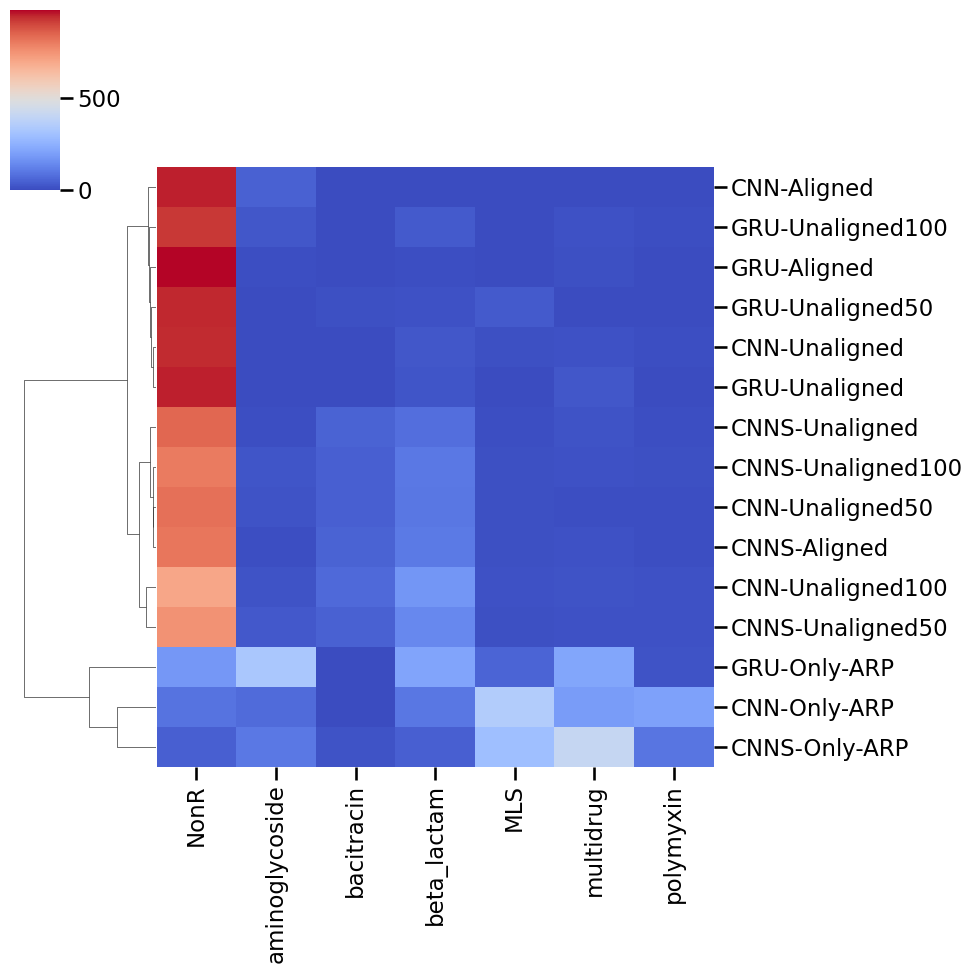

In [26]:
sn.set_context("talk")
sn.clustermap(pseudo_prot_long.T, col_cluster=False, cmap = "coolwarm")
plt.savefig("../../figs/hmd-pseudo-clustermap.svg", format = "SVG")

---

In [ ]:
pseudo_prot

,Pseudo,Sequence,CNN-Only-ARPs-class,CNN-Only-ARPs-prob,CNN-Aligned-class,CNN-Aligned-prob,CNN-Unaligned-class,CNN-Unaligned-prob,CNN-Unaligned50-class,CNN-Unaligned50-prob,...,GRU-Only-ARPs-class,GRU-Only-ARPs-prob,GRU-Aligned-class,GRU-Aligned-prob,GRU-Unaligned-class,GRU-Unaligned-prob,GRU-Unaligned50-class,GRU-Unaligned50-prob,GRU-Unaligned100-class,GRU-Unaligned100-prob
0,pseudo_0,L K P E H V Q I L T S T R S W L R Y R L P K R ...,multidrug,0.993,NonR,0.942,NonR,1.000,NonR,1.000,...,glycopeptide,0.945,NonR,1.000,NonR,0.994,NonR,0.290,NonR,NaN
1,pseudo_1,P L P P Y I A S K R A P D D R D A S D Y Q T M ...,multidrug,0.999,NonR,0.993,NonR,1.000,NonR,1.000,...,aminoglycoside,0.778,NonR,0.999,NonR,1.000,glycopeptide,0.584,NonR,NaN
2,pseudo_2,K A M P P K L L S D D G A N V V I R P L A Y C ...,multidrug,0.714,NonR,1.000,NonR,1.000,beta-lactam,0.987,...,NonR,0.406,NonR,0.905,NonR,0.868,NonR,0.510,NonR,NaN
3,pseudo_3,D F S L A E H N Q K T S I A Y Q G K I L M P I ...,multidrug,0.995,NonR,0.999,NonR,1.000,glycopeptide,0.990,...,glycopeptide,0.667,NonR,0.998,NonR,0.999,NonR,0.561,NonR,NaN
4,pseudo_4,P K K K T S K S K R D K R R A T W R H K A A V ...,NonR,0.467,NonR,0.996,NonR,0.986,NonR,1.000,...,aminoglycoside,0.933,NonR,1.000,NonR,0.994,rifamycin,0.629,NonR,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,pseudo_995,R K D E H I L Y A L E Q K S S Y N S F D E V E ...,multidrug,0.807,NonR,0.999,NonR,1.000,glycopeptide,1.000,...,glycopeptide,0.931,NonR,0.540,NonR,0.938,rifamycin,0.370,NonR,NaN
996,pseudo_996,Y T N D D W Y T D V E Y S H K Y L K A M F N F ...,multidrug,1.000,NonR,0.994,NonR,1.000,NonR,1.000,...,NonR,0.442,NonR,0.999,NonR,0.997,aminoglycoside,0.312,NonR,NaN
997,pseudo_997,D P G T M S P F Q H G E V F V T E D G A E T D ...,aminoglycoside,0.791,NonR,1.000,NonR,1.000,NonR,1.000,...,tetracycline,0.791,NonR,0.998,macrolide,0.644,rifamycin,0.306,NonR,NaN
998,pseudo_998,L K V F A G F V V T L A A A W G G F G Y L A G ...,multidrug,0.995,NonR,1.000,NonR,1.000,NonR,1.000,...,glycopeptide,0.979,NonR,0.966,NonR,0.996,NonR,0.609,NonR,NaN
